In [ ]:
!pip install transformers

     |████████████████████████████████| 3.5 MB 15.5 MB/s 
     |████████████████████████████████| 6.8 MB 53.1 MB/s 
     |████████████████████████████████| 67 kB 6.1 MB/s 
     |████████████████████████████████| 895 kB 49.0 MB/s 
     |████████████████████████████████| 596 kB 48.9 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
!pip install emoji

     |████████████████████████████████| 174 kB 31.5 MB/s 
  Created wheel for emoji: filename=emoji-1.6.3-py3-none-any.whl size=170298 sha256=b605bd838db98b22973e0659b174caf1c6daf70c5a27996117126307e531d17f
  Stored in directory: /root/.cache/pip/wheels/03/8b/d7/ad579fbef83c287215c0caab60fb0ae0f30c4d7ce5f580eade
Successfully built emoji


In [ ]:
#set seed for reproducibility
seed=42
import tensorflow as tf
import numpy as np
import tensorflow as tf
import sys
import pandas as pd
sys.path.append('models')
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
from sklearn.model_selection import train_test_split
#data processing
import re, string
import emoji
import nltk
from transformers import BertTokenizer
from transformers import TFBertModel
from tensorflow.keras.optimizers import Adam, SGD
#metrics
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
print("TF Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("GPU is", "available" if tf.config.experimental.list_physical_devices("GPU") else "NOT AVAILABLE")


TF Version:  2.7.0
Eager mode:  True
GPU is available


In [ ]:
df = pd.read_csv('data.csv')
print(df.shape)
df.head(10)
# label 0 == bearish
# label 1 == bullish 

(2900, 2)


,Post,label
0,"Yes, 2x growth (100% only) long-term estimate ...",1
1,Bitcoin is risen. Amen.,1
2,Bitcoin still to double from here,1
3,Just got a “Crypto markers are highly volatile...,1
4,Absolument. Bitcoin will soon be back on top.,1
5,bitcoin is the hardest money humanity has ever...,1
6,You're only going to get more stressed if you ...,0
7,Bitcoin will go beyond 40k by Monday. I know t...,0
8,maybe we will get some bullish action toward t...,1
9,Personally I think we consolidate for another ...,1


## **Let's Clean**

In the following, we will perform some data cleaning on the raw text of the posts.

In [ ]:
##CUSTOM DEFINED FUNCTIONS TO CLEAN THE POST

#Clean emojis from text
def strip_emoji(text):
    return re.sub(emoji.get_emoji_regexp(), r"", text) #remove emoji

#Remove punctuations, links, mentions and \r\n new line characters
def strip_all_entities(text): 
    text = text.replace('\r', '').replace('\n', ' ').replace('\n', ' ').lower() #remove \n and \r and lowercase
    text = re.sub(r"(?:\@|https?\://)\S+", "", text) #remove links and mentions
    text = re.sub(r'[^\x00-\x7f]',r'', text) #remove non utf8/ascii characters such as '\x9a\x91\x97\x9a\x97'
    banned_list= string.punctuation + 'Ã'+'±'+'ã'+'¼'+'â'+'»'+'§'
    table = str.maketrans('', '', banned_list)
    text = text.translate(table)
    return text

#clean hashtags at the end of the sentence, and keep those in the middle of the sentence by removing just the # symbol
def clean_hashtags(tweet):
    new_tweet = " ".join(word.strip() for word in re.split('#(?!(?:hashtag)\b)[\w-]+(?=(?:\s+#[\w-]+)*\s*$)', tweet)) #remove last hashtags
    new_tweet2 = " ".join(word.strip() for word in re.split('#|_', new_tweet)) #remove hashtags symbol from words in the middle of the sentence
    return new_tweet2

#Filter special characters such as & and $ present in some words
def filter_chars(a):
    sent = []
    for word in a.split(' '):
        if ('$' in word) | ('&' in word):
            sent.append('')
        else:
            sent.append(word)
    return ' '.join(sent)

def remove_mult_spaces(text): # remove multiple spaces
    return re.sub("\s\s+" , " ", text)

Now we can create a new column, for our dataset, to host the cleaned version of the Posts' text.

In [ ]:
texts_new = []
for t in df.Post:
    texts_new.append(remove_mult_spaces(filter_chars(clean_hashtags(strip_all_entities(strip_emoji(t))))))

In [ ]:
df['Post_clean'] = texts_new

In [ ]:
df.head(20)

,Post,label,Post_clean
0,"Yes, 2x growth (100% only) long-term estimate ...",1,yes 2x growth 100 only longterm estimate for b...
1,Bitcoin is risen. Amen.,1,bitcoin is risen amen
2,Bitcoin still to double from here,1,bitcoin still to double from here
3,Just got a “Crypto markers are highly volatile...,1,just got a crypto markers are highly volatile ...
4,Absolument. Bitcoin will soon be back on top.,1,absolument bitcoin will soon be back on top
5,bitcoin is the hardest money humanity has ever...,1,bitcoin is the hardest money humanity has ever...
6,You're only going to get more stressed if you ...,0,youre only going to get more stressed if you s...
7,Bitcoin will go beyond 40k by Monday. I know t...,0,bitcoin will go beyond 40k by monday i know th...
8,maybe we will get some bullish action toward t...,1,maybe we will get some bullish action toward t...
9,Personally I think we consolidate for another ...,1,personally i think we consolidate for another ...


# **. Let's Explore**<br>
**The Label Distribution**<br>
Here, we're going to walk through our label distribution. how long our data points are, make certain that our test and train sets are well distributed, and a few other preliminary tasks. First though, let's look at label distribution by running:

1    1941
0     959
Name: label, dtype: int64


Text(0.5, 1.0, 'Distribution of Labels')

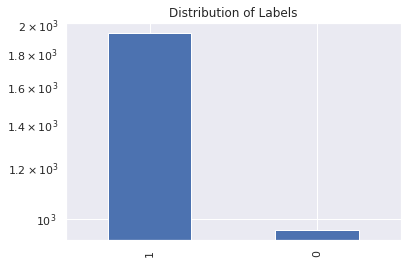

In [ ]:
print(df['label'].value_counts())
df['label'].value_counts().plot.bar()
plt.yscale('log');
plt.title('Distribution of Labels')

**Word Length and Character Length**<br>
Now, let's run a few lines of code to understand the text data we're working with here.

In [ ]:
print('Average word length of Post is {0:.0f}.'.format(np.mean(df['Post'].apply(lambda x: len(str(x).split())))))
print('Max word length of Post in dataset is {0:.0f}.'.format(np.max(df['Post'].apply(lambda x: len(str(x).split())))))
print('Average character length of Post in dataset is {0:.0f}.'.format(np.mean(df['Post'].apply(lambda x: len(str(x))))))

Average word length of Post is 15.
Max word length of Post in dataset is 76.
Average character length of Post in dataset is 83.


# 2. Preparing Training and Testing Data for Our BERT Text Classification Tasks

In [ ]:
train_df, valid_df = train_test_split(df, random_state=seed, train_size=0.8, stratify=df.label.values)
print(train_df.shape)
print(valid_df.shape) 

(2320, 3)
(580, 3)


**Getting the Word and Character Length for the Sampled Sets**


In [ ]:
print("FOR TRAIN SET\n")
print('Average word length of Post in train set is {0:.0f}.'.format(np.mean(train_df['Post'].apply(lambda x: len(str(x).split())))))
print('Max word length of Post in train set is {0:.0f}.'.format(np.max(train_df['Post'].apply(lambda x: len(str(x).split())))))
print('Average character length of Post in train set is {0:.0f}.'.format(np.mean(train_df['Post'].apply(lambda x: len(str(x))))))
print('Label Distribution in train set is \n{}.'.format(train_df['label'].value_counts()))
print("\n\nFOR VALIDATION SET\n")
print('Average word length of Post in valid set is {0:.0f}.'.format(np.mean(valid_df['Post'].apply(lambda x: len(str(x).split())))))
print('Max word length of Post in valid set is {0:.0f}.'.format(np.max(valid_df['Post'].apply(lambda x: len(str(x).split())))))
print('Average character length of Post in valid set is {0:.0f}.'.format(np.mean(valid_df['Post'].apply(lambda x: len(str(x))))))
print('Label Distribution in validation set is \n{}.'.format(valid_df['label'].value_counts()))

FOR TRAIN SET

Average word length of Post in train set is 14.
Max word length of Post in train set is 76.
Average character length of Post in train set is 83.
Label Distribution in train set is 
1    1553
0     767
Name: label, dtype: int64.


FOR VALIDATION SET

Average word length of Post in valid set is 15.
Max word length of Post in valid set is 59.
Average character length of Post in valid set is 85.
Label Distribution in validation set is 
1    388
0    192
Name: label, dtype: int64.


Analyzing the Distribution of Post Text Length in Words


Text(0.5, 1.0, 'Distribution of Post text length in words')

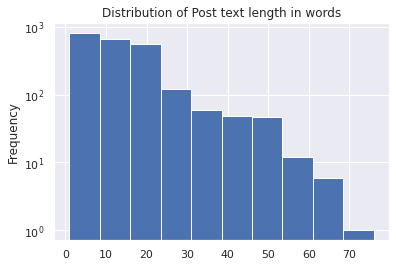

In [ ]:
# TRAIN SET 
train_df['Post'].apply(lambda x: len(str(x).split())).plot(kind='hist');
plt.yscale('log');
plt.title('Distribution of Post text length in words')


Text(0.5, 1.0, 'Distribution of Post text length in words')

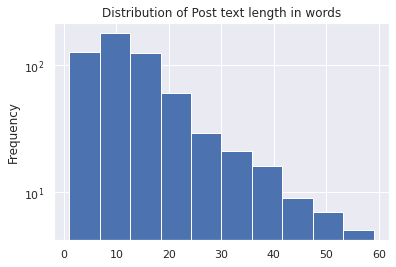

In [ ]:
# VALIDATION SET 
valid_df['Post'].apply(lambda x: len(str(x).split())).plot(kind='hist');
plt.yscale('log');
plt.title('Distribution of Post text length in words')

Analyzing the Distribution of Post Text Length in Characters

Text(0.5, 1.0, 'Distribution of Post text length in characters')

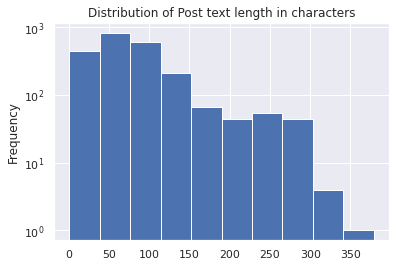

In [ ]:
# TRAIN SET
train_df['Post'].apply(lambda x: len(str(x))).plot(kind='hist');
plt.yscale('log');
plt.title('Distribution of Post text length in characters')

Text(0.5, 1.0, 'Distribution of Post text length in characters')

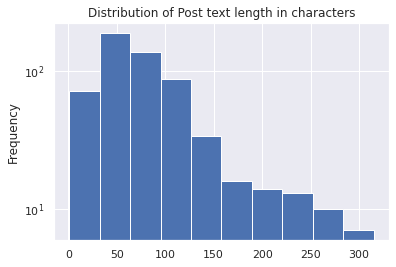

In [ ]:
# VALIDATION  SET
valid_df['Post'].apply(lambda x: len(str(x))).plot(kind='hist');
plt.yscale('log');
plt.title('Distribution of Post text length in characters')

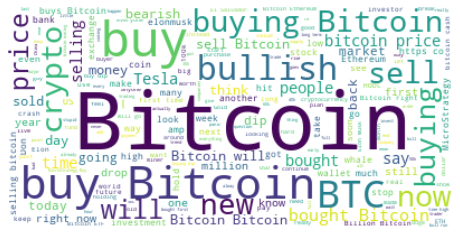

In [ ]:
from wordcloud import WordCloud
text = " ".join([x for x in df.Post])

wordcloud = WordCloud(background_color='white').generate(text)

plt.figure(figsize=(8,6))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')
plt.show()

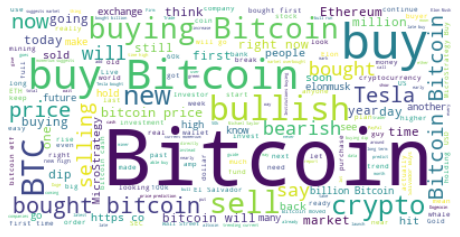

In [ ]:
## for bullish

text = " ".join([x for x in df.Post[df.label==1]])

wordcloud = WordCloud(background_color='white').generate(text)

plt.figure(figsize=(8,6))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')
plt.show()


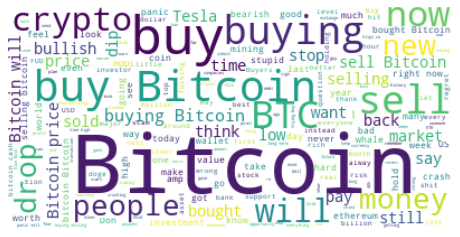

In [ ]:
## for bearish

text = " ".join([x for x in df.Post[df.label==0]])

wordcloud = WordCloud(background_color='white').generate(text)

plt.figure(figsize=(8,6))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')
plt.show()

# Let's BERT: Get the Pre-trained BERT Model from Hugging Face

We'll be using the uncased BERT present in the transformers. 
In order to prepare the text to be given to the BERT layer, we need to first tokenize our words. The tokenizer here is present as a model asset and will do uncasing for us as well.
Setting all parameters in the form of a dictionary so any changes, if needed, can be made here:

In [ ]:
# Setting some parameters
config = {'label_list' : [0, 1], # Label categories
          'max_seq_length' : 128, # maximum length of (token) input sequences
          'train_batch_size' : 32,
          'learning_rate': 1e-5,
          'epochs':7,
          'optimizer': 'adam',
          'dropout': 0.3
         }

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

**Checking out some of the training samples and their tokenized ids**


In [ ]:
input_string = "hello world, it is a wonderful day for learning"
print(tokenizer.wordpiece_tokenizer.tokenize(input_string))
print(tokenizer.convert_tokens_to_ids(tokenizer.wordpiece_tokenizer.tokenize(input_string)))

['hello', 'world', '##,', 'it', 'is', 'a', 'wonderful', 'day', 'for', 'learning']
[7592, 2088, 29623, 2009, 2003, 1037, 6919, 2154, 2005, 4083]


## **Encoding**


BERT uses 2 inputs: <br>

1) input_ids : List of token ids to be fed to the model<br>

2) attention_masks: List of indices specifying which tokens should be attended to by the model.

In [ ]:
def bert_encode(data,maximum_length) :
    input_ids = []
    attention_masks = []
    for i in range(len(data.Post_clean.values)):
        encoded = tokenizer.encode_plus(
        data.Post_clean.values[i],
        add_special_tokens=True,
        max_length=maximum_length,
        pad_to_max_length=True,
        truncation=True,
        return_attention_mask=True,
        
      )
      
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    return np.array(input_ids),np.array(attention_masks)

**Then, we apply the bert_encode function to the train, validation and test sets.**

In [ ]:
train_input_ids,train_attention_masks = bert_encode(train_df,config['max_seq_length'])
test_input_ids,test_attention_masks = bert_encode(valid_df,config['max_seq_length'])

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2257: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


**Now we can import the BERT model from the pretrained library from Hugging face.**

In [ ]:
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

Downloading:   0%|          | 0.00/511M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


**Creating model**

In [ ]:
def create_model(bert_model, max_len=config['max_seq_length']):
    input_ids = tf.keras.Input(shape=(max_len,),dtype='int32')
    attention_masks = tf.keras.Input(shape=(max_len,),dtype='int32')
    
    output = bert_model([input_ids,attention_masks])
    output = output[1]
  
    output = tf.keras.layers.Dense(768,activation='relu')(output)
    output = tf.keras.layers.Dropout(config['dropout'])(output)

    output = tf.keras.layers.Dense(1,activation='sigmoid')(output)
    model = tf.keras.models.Model(inputs = [input_ids,attention_masks],outputs = output)
    model.compile(Adam(lr=config['learning_rate']), loss='binary_crossentropy', metrics='accuracy')
    return model


In [ ]:
model = create_model(bert_model)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  109482240   ['input_3[0][0]',                
                                thPoolingAndCrossAt               'input_4[0][0]']                
                                tentions(last_hidde                                               
                                n_state=(None, 128,                                         

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


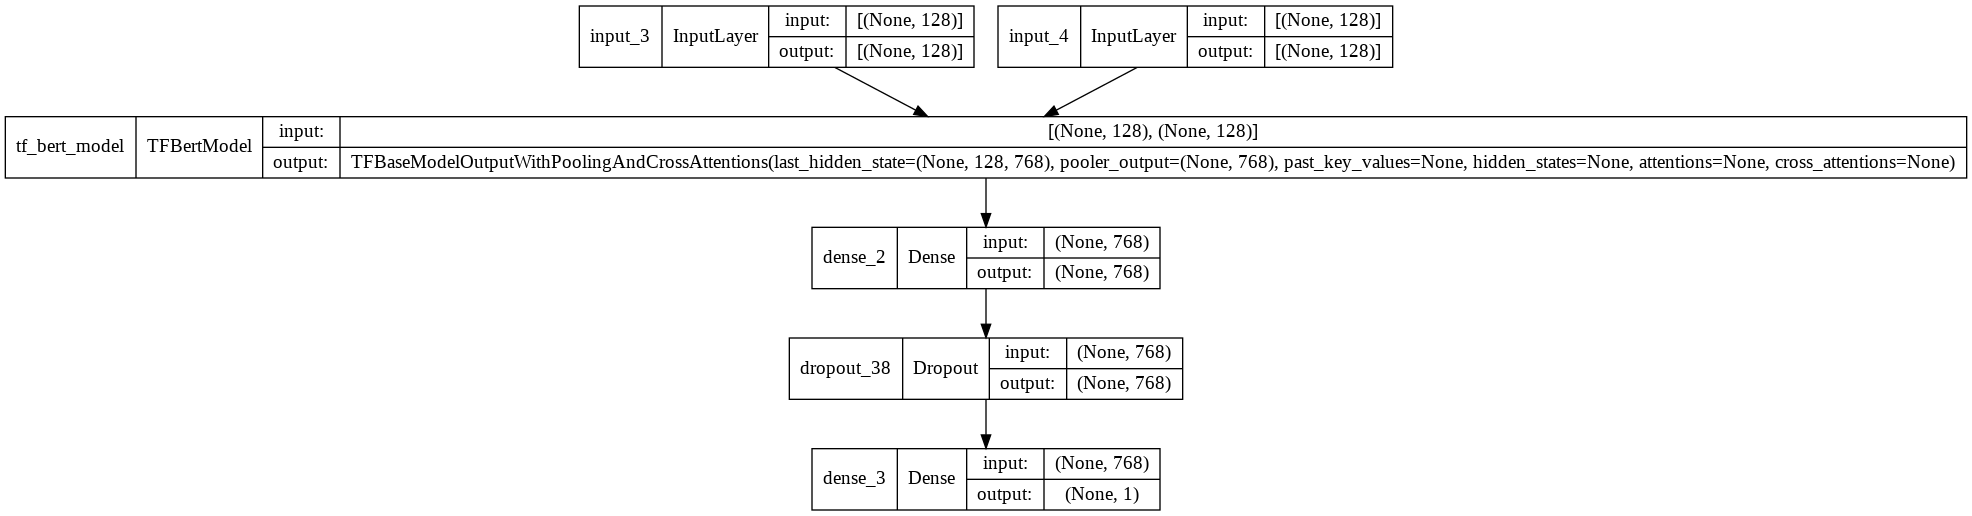

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png', expand_nested=True, show_shapes=True)

In [ ]:
y_train = train_df['label'].values
y_test = valid_df['label'].values

**Finally we can start fine tuning the BERT transformer !**

In [ ]:
history = model.fit([train_input_ids,train_attention_masks],y_train,validation_data=([test_input_ids,test_attention_masks],y_test), epochs=config['epochs'],batch_size=config['train_batch_size'])

NameError: ignored

**Visualizing BERT Performance**

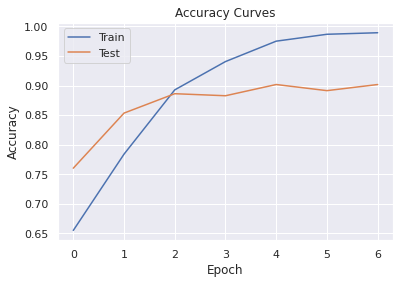

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy Curves')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

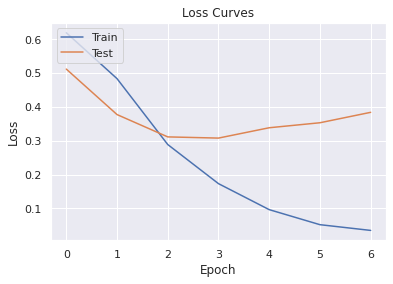

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Curves')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
def to_bin_vect(y) :
  result=[]
  for i in y :
    if i[0]>0.5 :
      result.append(1)
    else :
      result.append(0)
  return result

In [ ]:
result_bert = model.predict([test_input_ids,test_attention_masks])

In [ ]:
y_pred=to_bin_vect(result_bert)

In [ ]:
print('\tClassification Report for BERT:\n\n',classification_report(y_test ,y_pred, target_names=['Negative', 'Positive']))

	Classification Report for BERT:

               precision    recall  f1-score   support

    Negative       0.86      0.84      0.85       192
    Positive       0.92      0.93      0.93       388

    accuracy                           0.90       580
   macro avg       0.89      0.89      0.89       580
weighted avg       0.90      0.90      0.90       580



**Changing parameters** :<br>
1. dropout=0.5
2. leaning rate =2e^-5


In [ ]:
# Setting some parameters
config1 = {'label_list' : [0, 1], # Label categories
          'max_seq_length' : 128, # maximum length of (token) input sequences
          'train_batch_size' : 32,
          'learning_rate': 2e-5,
          'epochs':7,
          'optimizer': 'adam',
          'dropout': 0.5
         }

In [ ]:
def create_model(bert_model, max_len=config1['max_seq_length']):
    input_ids = tf.keras.Input(shape=(max_len,),dtype='int32')
    attention_masks = tf.keras.Input(shape=(max_len,),dtype='int32')
    
    output = bert_model([input_ids,attention_masks])
    output = output[1]
  
    output = tf.keras.layers.Dense(768,activation='relu')(output)
    output = tf.keras.layers.Dropout(config1['dropout'])(output)

    output = tf.keras.layers.Dense(1,activation='sigmoid')(output)
    model = tf.keras.models.Model(inputs = [input_ids,attention_masks],outputs = output)
    model.compile(Adam(lr=config1['learning_rate']), loss='binary_crossentropy', metrics='accuracy')
    return model


In [ ]:
model_1= create_model(bert_model)
model_1.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  109482240   ['input_5[0][0]',                
                                thPoolingAndCrossAt               'input_6[0][0]']                
                                tentions(last_hidde                                               
                                n_state=(None, 128,                                         

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
history1 = model_1.fit([train_input_ids,train_attention_masks],y_train,validation_data=([test_input_ids,test_attention_masks],y_test), epochs=config['epochs'],batch_size=config['train_batch_size'])

Epoch 1/7
73/73 [==============================] - 79s 885ms/step - loss: 0.1396 - accuracy: 0.9603 - val_loss: 0.3194 - val_accuracy: 0.9034
Epoch 2/7
73/73 [==============================] - 62s 846ms/step - loss: 0.0384 - accuracy: 0.9897 - val_loss: 0.3817 - val_accuracy: 0.9103
Epoch 3/7
73/73 [==============================] - 62s 847ms/step - loss: 0.0300 - accuracy: 0.9909 - val_loss: 0.4402 - val_accuracy: 0.9052
Epoch 4/7
73/73 [==============================] - 62s 846ms/step - loss: 0.0341 - accuracy: 0.9892 - val_loss: 0.4004 - val_accuracy: 0.9155
Epoch 5/7
73/73 [==============================] - 62s 847ms/step - loss: 0.0096 - accuracy: 0.9987 - val_loss: 0.4238 - val_accuracy: 0.9241
Epoch 6/7
73/73 [==============================] - 62s 848ms/step - loss: 0.0055 - accuracy: 0.9987 - val_loss: 0.5395 - val_accuracy: 0.9052
Epoch 7/7
73/73 [==============================] - 62s 848ms/step - loss: 0.0056 - accuracy: 0.9987 - val_loss: 0.4407 - val_accuracy: 0.9241


**Visualizing BERT Performance(model_1)** 

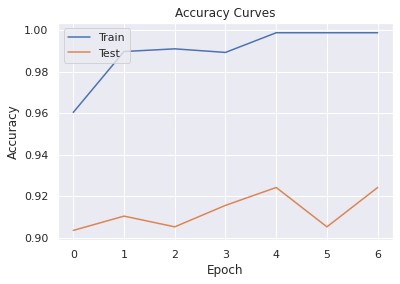

In [ ]:
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.title('Accuracy Curves')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

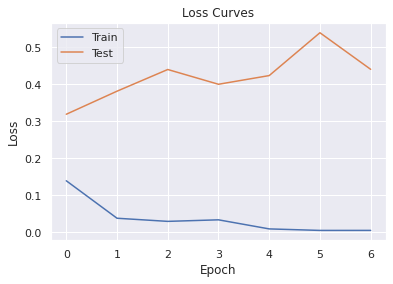

In [ ]:
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('Loss Curves')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
result_bert_1 = model_1.predict([test_input_ids,test_attention_masks])

In [ ]:
y_pred_1=to_bin_vect(result_bert_1)


In [ ]:
print('\tClassification Report for BERT:\n\n',classification_report(y_test ,y_pred_1, target_names=['Negative', 'Positive']))

	Classification Report for BERT:

               precision    recall  f1-score   support

    Negative       0.87      0.91      0.89       192
    Positive       0.95      0.93      0.94       388

    accuracy                           0.92       580
   macro avg       0.91      0.92      0.92       580
weighted avg       0.93      0.92      0.92       580



# Let's RoBERTa: Get the Pre-trained BERT Model from Hugging Face

As seen for BERT, we first import the tokenizer used to train the original roberta transformer.

In [ ]:
from transformers import RobertaTokenizerFast
from transformers import TFRobertaModel

In [ ]:
tokenizer_roberta = RobertaTokenizerFast.from_pretrained("roberta-base")

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [ ]:
def tokenize_roberta(data,max_len) :
    input_ids = []
    attention_masks = []
    for i in range(len(data.Post_clean.values)):
        encoded = tokenizer_roberta.encode_plus(
            data.Post_clean.values[i],
            add_special_tokens=True,
            max_length=max_len,
            padding='max_length',
            return_attention_mask=True
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    return np.array(input_ids),np.array(attention_masks)

In [ ]:
train_input_ids,train_attention_masks = tokenize_roberta(train_df,config['max_seq_length'])
test_input_ids,test_attention_masks = tokenize_roberta(valid_df,config['max_seq_length'])

**RoBERTa modeling**

In [ ]:
roberta_model = TFRobertaModel.from_pretrained('roberta-base')


Downloading:   0%|          | 0.00/627M [00:00<?, ?B/s]

Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


In [ ]:
# Setting some parameters
config1 = {'label_list' : [0, 1], # Label categories
          'max_seq_length' : 128, # maximum length of (token) input sequences
          'train_batch_size' : 32,
          'learning_rate': 2e-5,
          'epochs':7,
          'optimizer': 'adam',
          'dropout': 0.5
         }

In [ ]:
def create_model(bert_model, max_len=config1['max_seq_length']):
    input_ids = tf.keras.Input(shape=(max_len,),dtype='int32')
    attention_masks = tf.keras.Input(shape=(max_len,),dtype='int32')
    
    output = bert_model([input_ids,attention_masks])
    output = output[1]
  
    output = tf.keras.layers.Dense(768,activation='relu')(output)
    output = tf.keras.layers.Dropout(config1['dropout'])(output)

    output = tf.keras.layers.Dense(1,activation='sigmoid')(output)
    model = tf.keras.models.Model(inputs = [input_ids,attention_masks],outputs = output)
    model.compile(Adam(lr=config1['learning_rate']), loss='binary_crossentropy', metrics='accuracy')
    return model


In [ ]:
model_2= create_model(roberta_model)
model_2.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 input_8 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 tf_roberta_model (TFRobertaMod  TFBaseModelOutputWi  124645632  ['input_7[0][0]',                
 el)                            thPoolingAndCrossAt               'input_8[0][0]']                
                                tentions(last_hidde                                               
                                n_state=(None, 128,                                         

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
history2 = model_2.fit([train_input_ids,train_attention_masks],y_train,validation_data=([test_input_ids,test_attention_masks],y_test), epochs=config['epochs'],batch_size=config['train_batch_size'])

Epoch 1/7
73/73 [==============================] - 75s 823ms/step - loss: 0.5788 - accuracy: 0.7030 - val_loss: 0.3992 - val_accuracy: 0.8431
Epoch 2/7
73/73 [==============================] - 59s 807ms/step - loss: 0.3756 - accuracy: 0.8427 - val_loss: 0.3044 - val_accuracy: 0.8845
Epoch 3/7
73/73 [==============================] - 60s 821ms/step - loss: 0.2021 - accuracy: 0.9207 - val_loss: 0.2571 - val_accuracy: 0.9138
Epoch 4/7
73/73 [==============================] - 60s 829ms/step - loss: 0.1340 - accuracy: 0.9539 - val_loss: 0.2755 - val_accuracy: 0.9207
Epoch 5/7
73/73 [==============================] - 61s 833ms/step - loss: 0.0862 - accuracy: 0.9716 - val_loss: 0.2842 - val_accuracy: 0.9207
Epoch 6/7
73/73 [==============================] - 61s 835ms/step - loss: 0.0322 - accuracy: 0.9901 - val_loss: 0.4145 - val_accuracy: 0.9155
Epoch 7/7
73/73 [==============================] - 61s 836ms/step - loss: 0.0506 - accuracy: 0.9853 - val_loss: 0.3334 - val_accuracy: 0.9276


**Visualizing BERT Performance(model_1)** 

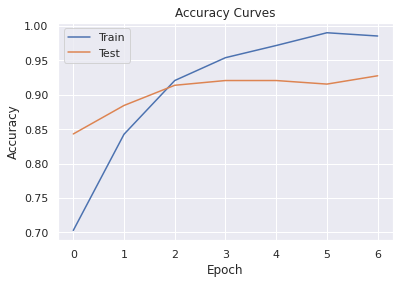

In [ ]:
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('Accuracy Curves')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

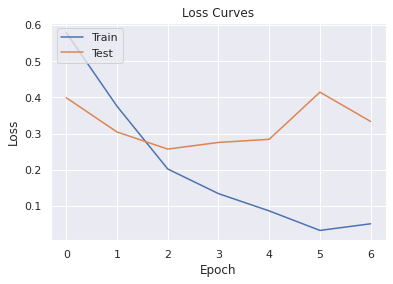

In [ ]:
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Loss Curves')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
result_bert_2 = model_2.predict([test_input_ids,test_attention_masks])

In [ ]:
y_pred_2=to_bin_vect(result_bert_2)

In [ ]:
print('\tClassification Report for BERT:\n\n',classification_report(y_test ,y_pred_2, target_names=['Negative', 'Positive']))

	Classification Report for BERT:

               precision    recall  f1-score   support

    Negative       0.89      0.90      0.89       192
    Positive       0.95      0.94      0.95       388

    accuracy                           0.93       580
   macro avg       0.92      0.92      0.92       580
weighted avg       0.93      0.93      0.93       580



# Let's Electra: Get the Pre-trained BERT Model from Hugging Face

In [ ]:
from transformers import ElectraTokenizer, ElectraForTokenClassification

In [ ]:
tokenizer_electra = ElectraTokenizer.from_pretrained("google/electra-small-discriminator")

In [ ]:
def tokenize_electra(data,max_len) :
    input_ids = []
    attention_masks = []
    for i in range(len(data.Post_clean.values)):
        encoded = tokenizer_electra.encode_plus(
            data.Post_clean.values[i],
            add_special_tokens=True,
            max_length=max_len,
            padding='max_length',
            return_attention_mask=True
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    return np.array(input_ids),np.array(attention_masks)

In [ ]:
train_input_ids,train_attention_masks = tokenize_electra(train_df,config['max_seq_length'])
test_input_ids,test_attention_masks = tokenize_electra(valid_df,config['max_seq_length'])

**Electra modeling**

In [ ]:
Electra_model = ElectraForTokenClassification.from_pretrained("google/electra-small-discriminator")

Some weights of the model checkpoint at google/electra-small-discriminator were not used when initializing ElectraForTokenClassification: ['discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense.bias', 'discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense.weight']
- This IS expected if you are initializing ElectraForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForTokenClassification were not initialized from the model checkpoint at google/electra-small-discriminator and are newly initialized: ['classifier.weight', 'c